In [5]:
import numpy as np
import pandas as pd
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt


In [4]:
def preprocessing():
    # Removes the dollar signs and commas
    def custom_dollar_converter(dollar_str):
        if '#' in dollar_str:
            return np.nan
        else:
            dollar_str = dollar_str.replace('$', '').replace(',', '')
            return float(dollar_str)
    
    # Determines whether a business is a franchise or not
    # If the value is 0 or 1, the business is not a franchise
    def custom_franchise_converter(franchise_str):
        if franchise_str.strip() == '0' or franchise_str.strip() == '1':
            return 0
        else:
            return 1
    
    # Trims zip codes to the first two numbers
    def zip_trimmer(zip_str):
        return zip_str[:2]
    
    # reads in data, using the custom converters
    bank_converters = {
        'DisbursementGross': custom_dollar_converter,
        'BalanceGross': custom_dollar_converter,
        'ChgOffPrinGr': custom_dollar_converter,
        'GrAppv': custom_dollar_converter,
        'SBA_Appv': custom_dollar_converter,
        'FranchiseCode': custom_franchise_converter,
        'Zip': zip_trimmer,
    }
    bank_parse_dates = [ 'ApprovalDate', 'ChgOffDate', 'DisbursementDate' ]

    df = pd.read_csv(
        'SBAnational.csv',
        converters=bank_converters,
        parse_dates=bank_parse_dates,
        date_parser=pd.to_datetime,
    )

    # drops unnecessary columns
    drop_columns = [
        'Name', 'City', 'ChgOffDate', 'DisbursementDate',
        'LoanNr_ChkDgt', 'Bank', 'NAICS',
        'CreateJob', 'RetainedJob', 'ChgOffPrinGr',
        'RevLineCr', 'LowDoc',
    ]
    working_df = df.drop(columns=drop_columns)
    
    # removes all null values
    working_df = working_df.dropna()
    
    
    # label encode MIS_Status
    mis_label_encoder = LabelEncoder()
    mis_encoded = mis_label_encoder.fit_transform(working_df['MIS_Status'])
    working_df['MIS_Status'] = mis_encoded
    
    
    # makes the NewExist variable more intuitive
    # a value of 1 means the business is new
    # a value of 0 means the business is not new
    working_df['NewExist'] = working_df['NewExist'].replace({ 2:1, 1:0 })
    # one hot encoding NewExist
    new_exist_true = working_df['NewExist'] == 1
    new_exist_false = working_df['NewExist'] == 0
    working_df['NewExistTrue'] = new_exist_true
    working_df['NewExistFalse'] = new_exist_false
    working_df = working_df.drop(columns=['NewExist'])
    
    # handling datetime information
    approval_date_months = working_df['ApprovalDate'].dt.month
    approval_date_days = working_df['ApprovalDate'].dt.day
    working_df['ApprovalMonth'] = approval_date_months
    working_df['ApprovalDay'] = approval_date_days
    working_df = working_df.drop(columns=['ApprovalDate'])

    approval_years = []
    for date in working_df['ApprovalFY']:
        if date == '1976A':
            approval_years.append(1976)
        else:
            approval_years.append(int(date))

    working_df['ApprovalFY'] = np.array(approval_years).astype(np.int64)
    
    
    # label encoding state information
    state_label_encoder = LabelEncoder()
    state_encoded = state_label_encoder.fit_transform(working_df['State'])
    bank_state_encoded = state_label_encoder.fit_transform(working_df['BankState'])
    working_df['State'] = state_encoded
    working_df['BankState'] = bank_state_encoded
    
    
    # converting zip information to the right datatype
    working_df['Zip'] = pd.to_numeric(working_df['Zip'])
    
    
    # separate data by features and target
    X = working_df.drop(columns=['MIS_Status'])
    y = working_df['MIS_Status']
    # separate the testing data from the training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # balancing the training data based on MIS_Status
    sampler = RandomOverSampler(sampling_strategy='minority')
    df_without_status, df_with_status = X_train, y_train
    df_without_status_rebalanced, df_with_status_rebalanced = sampler.fit_resample(
        df_without_status, df_with_status
    )
    X_train, y_train = df_without_status_rebalanced, df_with_status_rebalanced
    
    
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocessing()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.


Accuracy: 0.92
Precision: 0.95
Recall: 0.96
F1 score: 0.95
Confusion matrix:
[[ 24219   7251]
 [  6480 141152]]


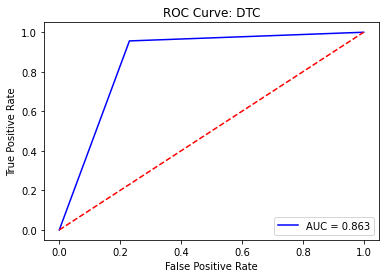

Running model: DTC, mean accuracy: 0.97404 +/- 0.00092
Running model: DTC, mean precision: 0.99857 +/- 0.00202
Running model: DTC, mean recall: 0.94944 +/- 0.00059
Running model: DTC, mean auc_scores: 0.97404 +/- 0.00092


In [6]:
# Instantiate and train the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")
print("Confusion matrix:")
print(conf_matrix)

# Plot the ROC Curve
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.title('ROC Curve: DTC')
plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Using Cross-Validation
model_name = 'DTC'
N_FOLDS = 5
scores = cross_val_score(model, X_train, y_train, cv=N_FOLDS)
print('Running model: ' + model_name + ', mean accuracy: %.5f +/- %.5f' % (np.mean(scores), np.std(scores)))
precision_scores = cross_val_score(model, X_train, y_train, cv=N_FOLDS, scoring="precision")
print('Running model: ' + model_name + ', mean precision: %.5f +/- %.5f' % (np.mean(precision_scores), np.std(precision_scores)))
recall_scores = cross_val_score(model, X_train, y_train, cv=N_FOLDS, scoring="recall")
print('Running model: ' + model_name + ', mean recall: %.5f +/- %.5f' % (np.mean(recall_scores), np.std(recall_scores)))
auc_scores = cross_val_score(model, X_train, y_train, cv=N_FOLDS, scoring="roc_auc")
print('Running model: ' + model_name + ', mean auc_scores: %.5f +/- %.5f' % (np.mean(auc_scores), np.std(auc_scores)))